## A secret - beheading neural networks

Training good neural networks for vision tasks requires a lot of data. For example the ImageNet dataset contains 1000 classes and a total of ~10million images. Most people do not have access to an annotated dataset of similar size. As a result what is often done is to train a network based on the the ImageNet data and then either:

* chop off the final fully connected layer(s), hook up a simple fully-connected network and train it with your data
* freeze the weights in all but the last few layers, fine tune the weights in those with your dataset

You can treat a whole neural network as a single "building block" in your setup. As long as it is differentiable you do not really care what is inside, you can keep building on top of it and keep training via back propagation.

A good example of training with a (very) small dataset: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


<img src="convnet.png" width="500px" />

---

## Getting technical here

Below we load a ResNet50 pretrained model. Use it to extract features for images from the Pascal VOC dataset.

(This code is based on https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/03_conv_nets/Pretrained_ConvNets_with_Keras_rendered.ipynb to run it you will have to install `h5py` and `pillow`: `conda install h5py pillow`)

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image

model = ResNet50(include_top=True, weights='imagenet')

Using TensorFlow backend.


Now load an example image and feed it through the model.

In [3]:
# unzip some example images
import os.path as op
from zipfile import ZipFile

if not op.exists("images_resize"):
    print('Extracting image files...')
    zf = ZipFile('images_pascalVOC.zip')
    zf.extractall('.')

warplane 0.816914
wing 0.0869485
airliner 0.0546439
airship 0.0199897
missile 0.00716218


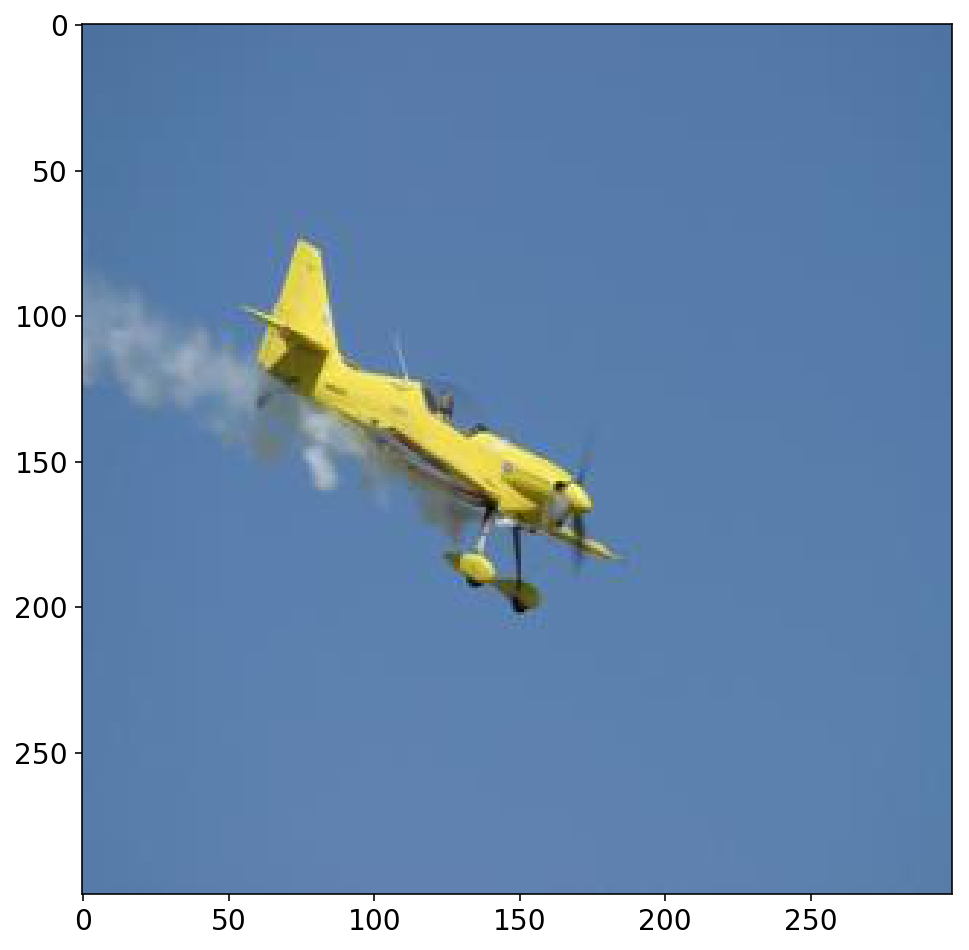

In [5]:
from scipy.misc import imread, imresize
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

path = "images_resize/000007.jpg"
path = "images_resize/000005.jpg"
path = "images_resize/000228.jpg"
#path = "images_resize/000486.jpg"

img = imread(path)
plt.imshow(img)

img = imresize(img, (224,224)).astype("float32")
# add a dimension for a "batch" of 1 image
img_batch = preprocess_input(img[np.newaxis]) 

predictions = model.predict(img_batch)
decoded_predictions= decode_predictions(predictions)

for s, name, score in decoded_predictions[0]:
    print(name, score)

## Compute an image's representation

Remove last layer from the network, use these outputs as new features.

In [6]:
input = model.layers[0].input
output = model.layers[-2].output
short_model = Model(input, output)

In [7]:
representation = short_model.predict(img_batch)
print("shape of representation:", representation.shape)
# we now have a 2048 dimensional representation

shape of representation: (1, 2048)


### Here is one I prepared earlier

We would now have to compute representations for all these images. Takes a while and is boring to watch. Precomputed representations:

In [8]:
import h5py

# Load pre-calculated representations
h5f = h5py.File('img_emb.h5','r')
out_tensors = h5f['img_emb'][:]
h5f.close()

How good are these representations? Can we look at them? Yes, use a non-linear dimensionality reduction algorithm called TSNE.

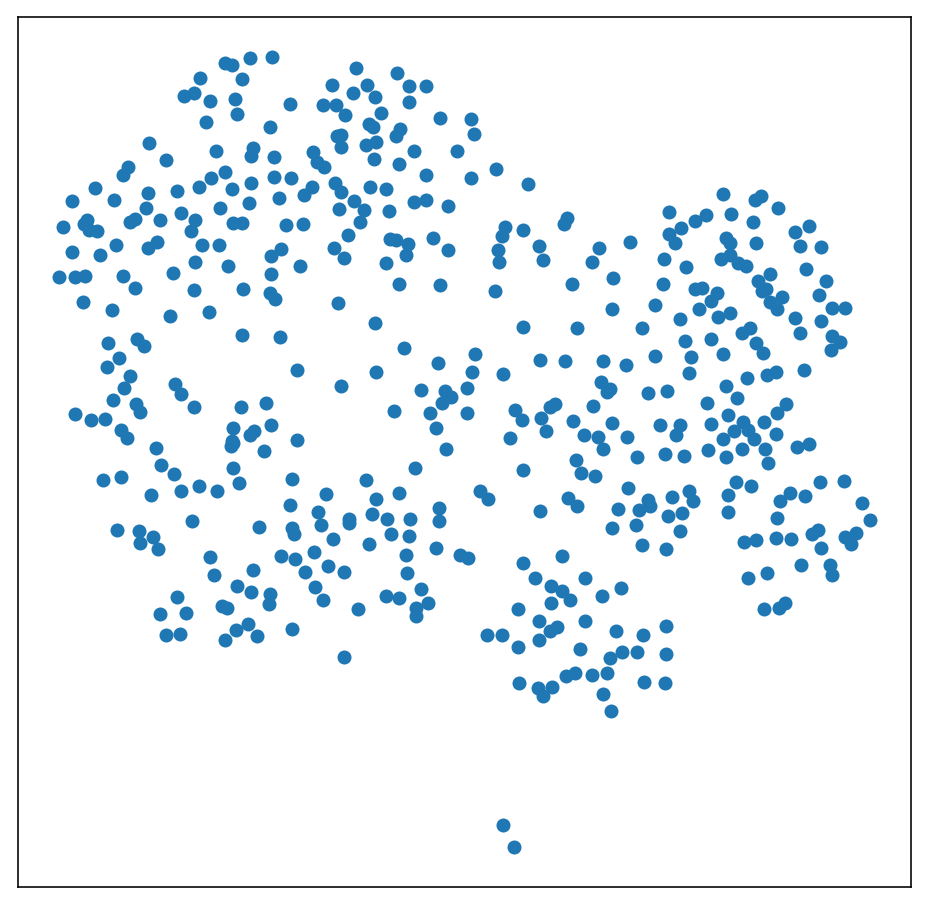

In [9]:
from sklearn.manifold import TSNE

img_emb_tsne = TSNE(perplexity=30).fit_transform(out_tensors)
plt.scatter(img_emb_tsne[:,0], img_emb_tsne[:,1])
plt.xticks(())
plt.yticks(());

In [10]:
from sklearn.neighbors import KDTree

tree = KDTree(img_emb_tsne)

In [11]:
import os
paths = ["images_resize/" + path
         for path in sorted(os.listdir("images_resize/"))]

In [28]:
distance, query_inds = tree.query([img_emb_tsne[20]], k=3)
distance, query_inds = tree.query([img_emb_tsne[0]], k=3)
distance, query_inds = tree.query([img_emb_tsne[40]], k=3)
distance, query_inds = tree.query([img_emb_tsne[1]], k=3)
print(query_inds)

[[  1  90 314]]


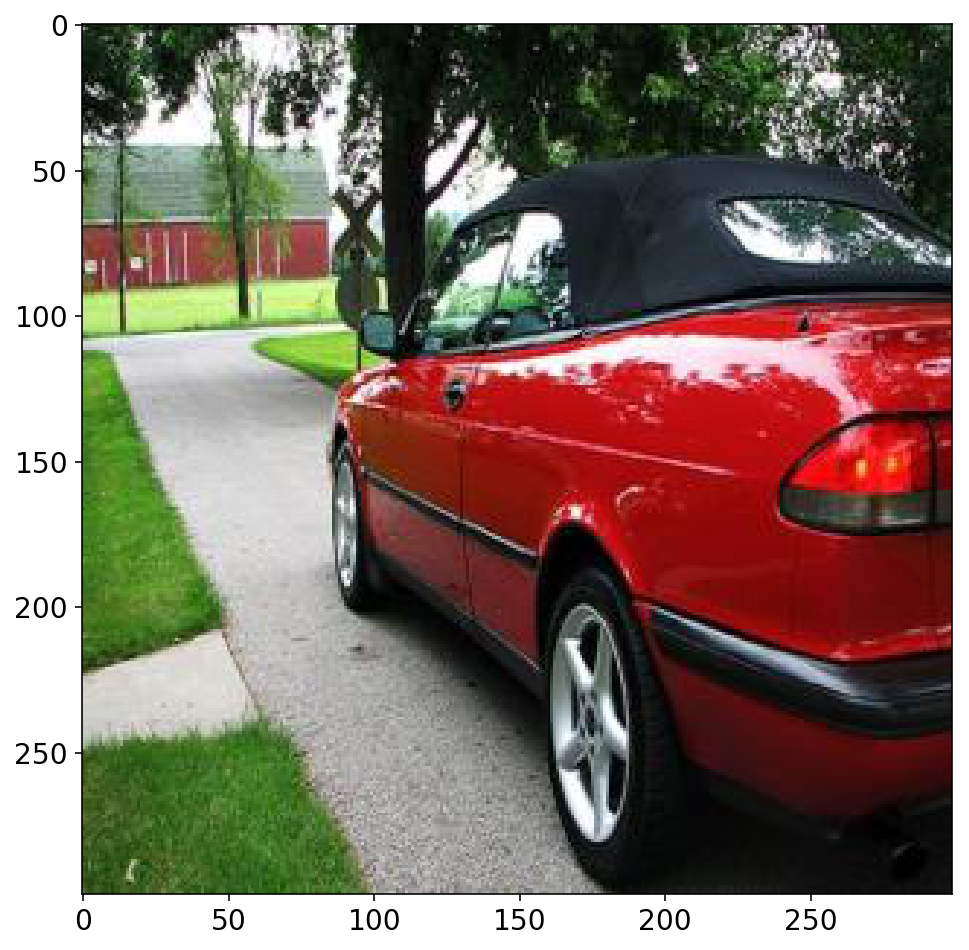

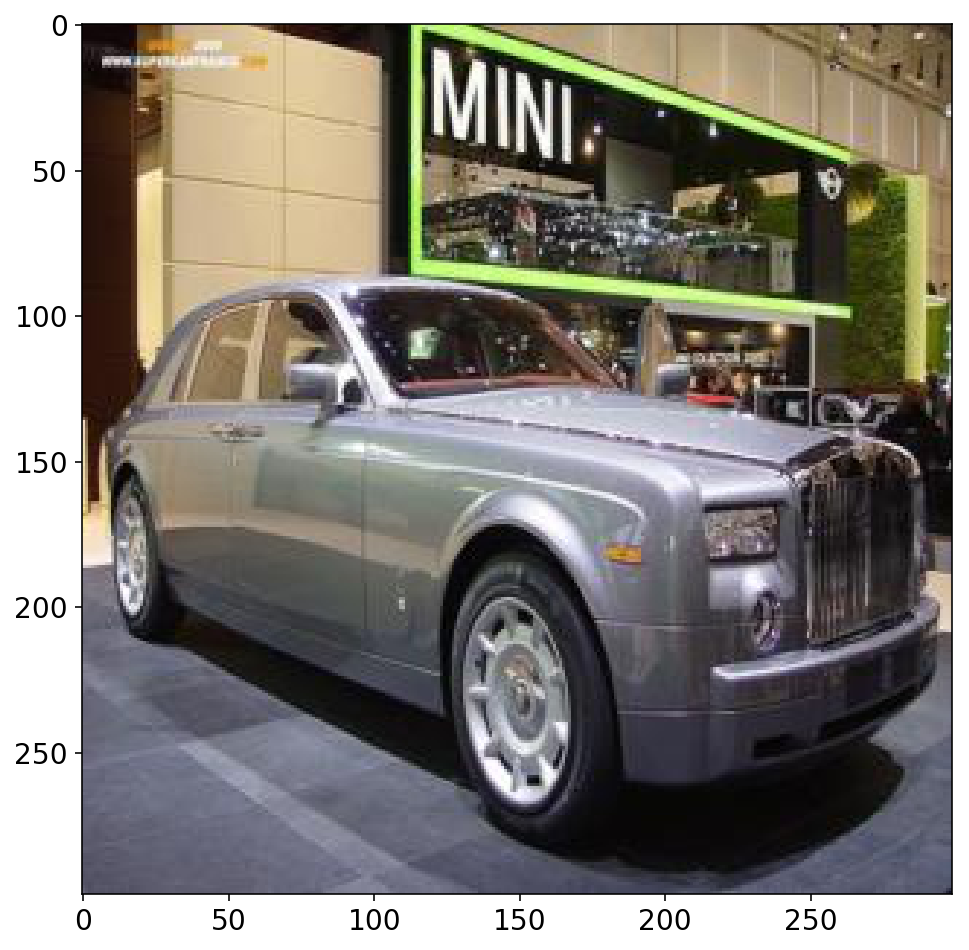

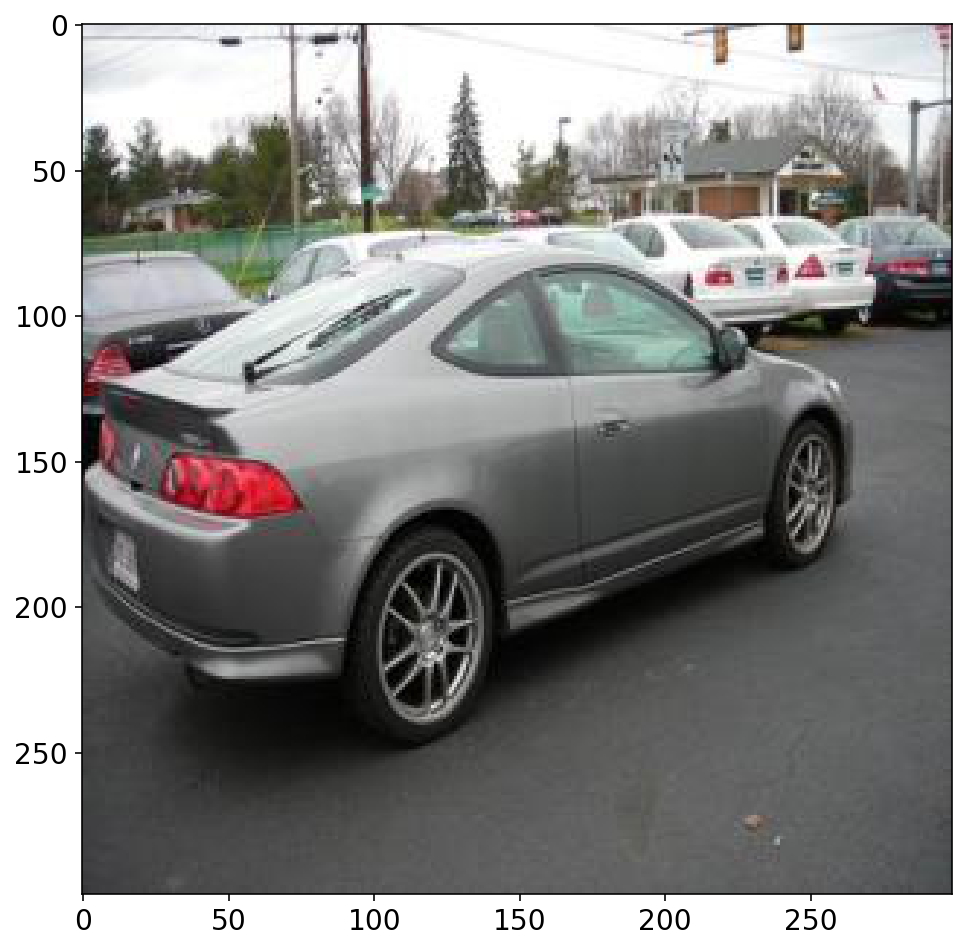

In [29]:
for idx in query_inds[0]:
    fig = plt.figure()
    img = imread(paths[idx])
    plt.imshow(img)
    plt.show()